In [255]:
import pandas as pd 
import numpy as np
import requests
import tweepy
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Data Wrangling
### 1- Data Gathering


In [256]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

#### I used 'Request' to download image_predictions
    

In [257]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(URL)
with open ("image_predictions.tsv", mode ='wb') as file:
    file.write(r.content)

In [258]:
image_predictions = pd.read_csv("image_predictions.tsv",sep='\t')

In [259]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### Twitter API Authentication


In [260]:
auth = tweepy.OAuthHandler('5Uur0mo4ol2kB8yhtZ1VxXS0u', 'h8E7fSpXWiMoBel7G1ZOAeu4Mgru0v0MtxH5ehYE1RKM89SiBH')
auth.set_access_token('303562412-ct9aNnU0FQR0UKJVn1i1W3Y8omqSewiQWUcRaygB', 'D3qslrbdOU5fqTOp951kOIuZbkeTPBodnjNYoEGFR63Ft')
api = tweepy.API(auth, wait_on_rate_limit=True)

In [261]:
tweet_ids = twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

2356

In [262]:
# Using Twitter's API for extracting JSON data for each tweet ID in the Twitter archive
# Save each tweet's returned JSON in a .txt file
fails_dict = {}
count =0
if not os.path.exists('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in tweet_ids:
            count = count + 1
            try:
                tweet = api.get_status(tweet_id,wait_on_rate_limit =True,wait_on_rate_limit_notify = True,tweet_mode='extended')
                json.dump(tweet._json, outfile)
                outfile.write('\n')
                print(count , " : Success")
            except tweepy.TweepError as e:
                fails_dict[tweet_id] = e
                print(count , " : Fail")
                pass
print(fails_dict)

{}


In [263]:
len(fails_dict)

0

In [264]:
data = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    for line in json_file:
        element = json.loads(line)
        tweet_id = element['id']
        tweet_txt = element['full_text']
        url = tweet_txt[tweet_txt.find('https'):]
        favorite_count = element['favorite_count']
        retweet_count = element['retweet_count']
        retweeted_status = element['retweeted_status'] = element.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        data.append({'tweet_id': str(tweet_id),
                             'tweet_txt':tweet_txt,
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'url': url,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(data, columns = ['tweet_id','tweet_txt' ,'favorite_count','retweet_count',  
                                                           'retweeted_status', 'url'])

### 2- Assessing Data
*First*: Visually   -----   Second: Programaticly

there are many NAN values in in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id	retweeted_status_user_id	

In [265]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [266]:
tweet_json

,tweet_id,tweet_txt,favorite_count,retweet_count,retweeted_status,url
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35295,7445,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,This is Tilly. She's just checking pup on you....,30522,5531,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22964,3655,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38574,7619,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,This is Franklin. He would like you to stop ca...,36851,8205,Original tweet,https://t.co/AtUZn91f7f
...,...,...,...,...,...,...
2326,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,95,39,Original tweet,https://t.co/4B7cOc1EDq
2327,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,263,123,Original tweet,https://t.co/DWnyCjf2mx
2328,666033412701032449,Here is a very happy pup. Big fan of well-main...,108,39,Original tweet,https://t.co/y671yMhoiR
2329,666029285002620928,This is a western brown Mitsubishi terrier. Up...,118,41,Original tweet,https://t.co/r7mOb2m0UI


In [267]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


## Programatically

In [268]:
print(twitter_archive_enhanced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [269]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### No Duplicated Values

In [270]:
twitter_archive_enhanced['tweet_id'].duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2351    False
2352    False
2353    False
2354    False
2355    False
Name: tweet_id, Length: 2356, dtype: bool

In [271]:
twitter_archive_enhanced['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [272]:
twitter_archive_enhanced['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Checking tweets with wrong rating_numerator and rating_denominator

In [273]:
print(twitter_archive_enhanced[twitter_archive_enhanced['rating_denominator'] != 10].shape)
twitter_archive_enhanced[twitter_archive_enhanced['rating_denominator'] != 10]

(23, 17)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [274]:
twitter_archive_enhanced[twitter_archive_enhanced['rating_denominator'] != 10].tweet_id

313     835246439529840640
342     832088576586297345
433     820690176645140481
516     810984652412424192
784     775096608509886464
902     758467244762497024
1068    740373189193256964
1120    731156023742988288
1165    722974582966214656
1202    716439118184652801
1228    713900603437621249
1254    710658690886586372
1274    709198395643068416
1351    704054845121142784
1433    697463031882764288
1598    686035780142297088
1634    684225744407494656
1635    684222868335505415
1662    682962037429899265
1663    682808988178739200
1779    677716515794329600
1843    675853064436391936
2335    666287406224695296
Name: tweet_id, dtype: int64

In [275]:
ids = twitter_archive_enhanced[twitter_archive_enhanced['rating_denominator'] != 10].tweet_id.index
for id in range(len(ids)):
    print(ids[id],":",twitter_archive_enhanced.text[ids[id]])

313 : @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342 : @docmisterio account started on 11/15/15
433 : The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516 : Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784 : RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902 : Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068 : After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1120 : Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165 : Happy 4/20 from the squad! 13/10 for all https://t.c

### there are float values which require converting data type to flaot

In [276]:
ids_num = twitter_archive_enhanced[twitter_archive_enhanced['rating_numerator'] > 18][twitter_archive_enhanced['rating_denominator'] == 10].tweet_id.index
ids_num   
for id in range(len(ids_num)):
    print(ids_num[id],":",twitter_archive_enhanced.text[ids_num[id]])

188 : @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189 : @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
290 : @markhoppus 182/10
340 : RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
695 : This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
763 : This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
979 : This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1712 : Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
2074 : After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY


<ipython-input-276-3fe566b13d67>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ids_num = twitter_archive_enhanced[twitter_archive_enhanced['rating_numerator'] > 18][twitter_archive_enhanced['rating_denominator'] == 10].tweet_id.index


In [277]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [278]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [279]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


   ### removing 66 duplicated jpg_url

In [280]:
sum(image_predictions.jpg_url.duplicated())

66

In [281]:
image_predictions['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [282]:
not_dog_type = image_predictions[image_predictions['p1_dog'] == False][image_predictions['p2_dog'] == False][image_predictions['p3_dog'] == False]
not_dog_type

<ipython-input-282-15e1bc417c92>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_dog_type = image_predictions[image_predictions['p1_dog'] == False][image_predictions['p2_dog'] == False][image_predictions['p3_dog'] == False]
<ipython-input-282-15e1bc417c92>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  not_dog_type = image_predictions[image_predictions['p1_dog'] == False][image_predictions['p2_dog'] == False][image_predictions['p3_dog'] == False]


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


In [283]:
tweet_json.head()

,tweet_id,tweet_txt,favorite_count,retweet_count,retweeted_status,url
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35295,7445,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,This is Tilly. She's just checking pup on you....,30522,5531,Original tweet,https://t.co/0Xxu71qeIV
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22964,3655,Original tweet,https://t.co/wUnZnhtVJB
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38574,7619,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,This is Franklin. He would like you to stop ca...,36851,8205,Original tweet,https://t.co/AtUZn91f7f


In [284]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2331 non-null   object
 1   tweet_txt         2331 non-null   object
 2   favorite_count    2331 non-null   int64 
 3   retweet_count     2331 non-null   int64 
 4   retweeted_status  2331 non-null   object
 5   url               2331 non-null   object
dtypes: int64(2), object(4)
memory usage: 109.4+ KB


### 163 retweets need to be removed

In [285]:
tweet_json['retweeted_status'].value_counts()

Original tweet       2168
This is a retweet     163
Name: retweeted_status, dtype: int64

In [286]:
tweet_json[tweet_json['retweeted_status']=='This is a retweet']

,tweet_id,tweet_txt,favorite_count,retweet_count,retweeted_status,url
31,886054160059072513,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,0,96,This is a retweet,This is a retweet
35,885311592912609280,RT @dog_rates: This is Lilly. She just paralle...,0,16313,This is a retweet,This is a retweet
67,879130579576475649,RT @dog_rates: This is Emmy. She was adopted t...,0,6026,This is a retweet,This is a retweet
72,878404777348136964,RT @dog_rates: Meet Shadow. In an attempt to r...,0,1126,This is a retweet,This is a retweet
73,878316110768087041,RT @dog_rates: Meet Terrance. He's being yelle...,0,5871,This is a retweet,This is a retweet
...,...,...,...,...,...,...
999,746521445350707200,RT @dog_rates: This is Shaggy. He knows exactl...,0,956,This is a retweet,This is a retweet
1019,743835915802583040,RT @dog_rates: Extremely intelligent dog here....,0,1998,This is a retweet,This is a retweet
1218,711998809858043904,RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,0,123,This is a retweet,This is a retweet
2234,667550904950915073,RT @dogratingrating: Exceptional talent. Origi...,0,31,This is a retweet,This is a retweet


# Define
## Quality issues

   ### twitter_archive_enhanced-data:
    - Drop retweets by filtering the NaN of retweeted_status_user_id
    - Many NaN values in in_reply_to_status_id, in_reply_to_user_id,retweeted_status_timestamp, retweeted_status_id and retweeted_status_user_id columns
    - The Source column data is invalid and needs cleaning "HTML tags"
    - Correct Invalid rating_numerator values and drop exetrem values.
        - Correct numerators with decimals
    - Correct Invalid rating_denominator values and drop exetrem values.
      - Manually (assessed by individual print text).
      - programarlly(Tweets with denominator not equal to 10 are usually multiple dogs).
    - timestamp column format is string and needs to be splited onto 3 columns
    - convert floar numerator_rating

   ### image_prediction:
    - Removing retweets will make retweeted_status column useless.
    - Drop jpg_url (duplicated)
    - Create 1 column for image prediction and 1 column for confidence level
   ### tweet_json:
    - Drop retweets

## Tidiness issues
- Change tweet_id to type int64 in order to merge with the other 2 tables
- Merge doggo, floofer, pupper and puppo into a single column called dog stage.
- Merging three data sets into one


# Data cleaning

- Make a copy of the original data set 

In [287]:
twitter_archive_clean = twitter_archive_enhanced.copy()
image_prediction_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

# define
### 1- Drop retweets by filtering the NaN of retweeted_status_user_id

### Code

In [288]:
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]


### test

In [289]:
#TEST
print(sum(twitter_archive_clean.retweeted_status_user_id.value_counts()))

0


# Define
### 2- Drop columns with alot of null values that won't be used for analysis

### Code

In [290]:
twitter_archive_clean = twitter_archive_clean.drop(['source','in_reply_to_status_id',
                                                       'in_reply_to_user_id','retweeted_status_id',
                                                       'retweeted_status_user_id','retweeted_status_timestamp',
                                                      'expanded_urls'], axis= 1)

### Test

In [291]:
# TESt
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   text                2175 non-null   object
 3   rating_numerator    2175 non-null   int64 
 4   rating_denominator  2175 non-null   int64 
 5   name                2175 non-null   object
 6   doggo               2175 non-null   object
 7   floofer             2175 non-null   object
 8   pupper              2175 non-null   object
 9   puppo               2175 non-null   object
dtypes: int64(3), object(7)
memory usage: 186.9+ KB


# Define
### 3- split timestamp int three columns (year, month, day)

- split timestamp column into three columns (day - month - year)
- Then drop timestamp column

### Code

In [292]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_enhanced['timestamp'])

twitter_archive_clean['year'] = twitter_archive_clean['timestamp'].dt.year
twitter_archive_clean['month'] = twitter_archive_clean['timestamp'].dt.month
twitter_archive_clean['day'] = twitter_archive_clean['timestamp'].dt.day

twitter_archive_clean = twitter_archive_clean.drop('timestamp', axis=1)

### Test

In [293]:
#Test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   text                2175 non-null   object
 2   rating_numerator    2175 non-null   int64 
 3   rating_denominator  2175 non-null   int64 
 4   name                2175 non-null   object
 5   doggo               2175 non-null   object
 6   floofer             2175 non-null   object
 7   pupper              2175 non-null   object
 8   puppo               2175 non-null   object
 9   year                2175 non-null   int64 
 10  month               2175 non-null   int64 
 11  day                 2175 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 220.9+ KB


# Define

### 4-Remove HTML Tags from sourcr url

## Code

In [294]:
twitter_archive_clean['source'] = twitter_archive_enhanced['source'].str.split('"')
for i in range(len(twitter_archive_clean['source'].values)):
    twitter_archive_clean['source'][i] = twitter_archive_clean['source'].values[i][1]

<ipython-input-294-02d26e997753>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_clean['source'][i] = twitter_archive_clean['source'].values[i][1]


## Test

In [295]:
twitter_archive_clean['source']

0                      http://twitter.com/download/iphone
1                      http://twitter.com/download/iphone
2                      http://twitter.com/download/iphone
3                      http://twitter.com/download/iphone
4                      http://twitter.com/download/iphone
                              ...                        
2351    [<a href=, http://twitter.com/download/iphone,...
2352    [<a href=, http://twitter.com/download/iphone,...
2353    [<a href=, http://twitter.com/download/iphone,...
2354    [<a href=, http://twitter.com/download/iphone,...
2355    [<a href=, http://twitter.com/download/iphone,...
Name: source, Length: 2175, dtype: object

In [296]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   text                2175 non-null   object
 2   rating_numerator    2175 non-null   int64 
 3   rating_denominator  2175 non-null   int64 
 4   name                2175 non-null   object
 5   doggo               2175 non-null   object
 6   floofer             2175 non-null   object
 7   pupper              2175 non-null   object
 8   puppo               2175 non-null   object
 9   year                2175 non-null   int64 
 10  month               2175 non-null   int64 
 11  day                 2175 non-null   int64 
 12  source              2175 non-null   object
dtypes: int64(6), object(7)
memory usage: 317.9+ KB


## Define
### 5-correct numerator data type to float to support decimals

### Code

In [297]:
twitter_archive_clean = twitter_archive_clean.astype({'rating_numerator': 'float64', 'rating_denominator': 'float64'})

## Test

In [298]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   text                2175 non-null   object 
 2   rating_numerator    2175 non-null   float64
 3   rating_denominator  2175 non-null   float64
 4   name                2175 non-null   object 
 5   doggo               2175 non-null   object 
 6   floofer             2175 non-null   object 
 7   pupper              2175 non-null   object 
 8   puppo               2175 non-null   object 
 9   year                2175 non-null   int64  
 10  month               2175 non-null   int64  
 11  day                 2175 non-null   int64  
 12  source              2175 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 317.9+ KB


# define


#### 6- Correct Invalid rating_numerator values


### Code

In [299]:
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

## Test

In [300]:
with pd.option_context('max_colwidth', 200):
    display(twitter_archive_clean[twitter_archive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\belal\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.50,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0


#### 7-Correct denominators


In [301]:
fix_required = {"313":[13 , 10],"433":[12,10],"784":[14,10],"340":[9.75,10],
                "902":[11,10],"1068":[14,10],"1165":[13,10],"695":[9.75,10],
                "1202":[11,10],"1228":[11,10],"1254":[10,10],"763":[11.27,1],
                "1351":[12,10],"1433":[11,10],"1598":[2,10],"1634":[11,10],
                "1635":[11,10],"1662":[10,10],"1779":[12,10],"1843":[11,10],
                "2335":[9,10],"1712":[11.26,10]}
drop_this_rating = [340,516,1120,1274,1663]
drop_this_rating2 = [188,189,290,2074,979]

### Code
#### Drop no rating tweets

In [302]:
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 740373189193256964), 'rating_numerator'] = 14
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 740373189193256964), 'rating_denominator'] = 10

twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 682962037429899265), 'rating_numerator'] = 10
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 682962037429899265), 'rating_denominator'] = 10

twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 666287406224695296), 'rating_numerator'] = 9
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 666287406224695296), 'rating_denominator'] = 10

twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 722974582966214656), 'rating_numerator'] = 13
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 722974582966214656), 'rating_denominator'] = 10
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 716439118184652801), 'rating_numerator'] = 13.5
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 716439118184652801), 'rating_denominator'] = 10

#Delete five tweets with no actual ratings
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != 832088576586297345]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != 810984652412424192]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != 682808988178739200]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != 835246439529840640]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['tweet_id'] != 686035780142297088]


### Test

In [303]:
with pd.option_context('max_colwidth', 200):
    display(twitter_archive_clean[twitter_archive_clean['rating_denominator'] != 10][['tweet_id',
                                                                                      'text',
                                                                                      'rating_numerator',
                                                                                      'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
1634,684225744407494656,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0


#### Programatically
These tweets with denominator not equal to 10 are multiple dogs. For example, tweet_id 713900603437621000 has numerator and denominators 99/90 because there are 9 dogs in the picture https://t.co/mpvaVxKmc1.

In [304]:
twitter_archive_clean['rating'] = 10 * twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator'].astype(float)

### Test


In [305]:
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,month,day,source,rating
154,862096992088072192,We only rate dogs. Please don't send perfectly...,13.0,10.0,None,None,None,None,None,2017,5,10,http://twitter.com/download/iphone,13.0
1559,688547210804498433,This is Frönq. He got caught stealing a waffle...,9.0,10.0,Frönq,None,None,None,None,2016,1,17,http://twitter.com/download/iphone,9.0
1474,693644216740769793,BREAKING PUPDATE: I've just been notified that...,10.0,10.0,None,None,None,None,None,2016,1,31,http://twitter.com/download/iphone,10.0
1899,674670581682434048,Meet Jeb &amp; Bush. Jeb is somehow stuck in t...,9.0,10.0,Jeb,None,None,None,None,2015,12,9,http://twitter.com/download/iphone,9.0
1314,706901761596989440,This is Elliot. He's blocking the roadway. Dow...,3.0,10.0,Elliot,None,None,None,None,2016,3,7,http://twitter.com/download/iphone,3.0


## tweet_json file
## define
7- Drop retweets then drop retweeted status columns 

### code

In [306]:
tweet_json_clean = tweet_json[tweet_json['retweeted_status'] == 'Original tweet']

In [307]:
tweet_json_clean['retweeted_status'].value_counts()

Original tweet    2168
Name: retweeted_status, dtype: int64

In [308]:
tweet_json_clean.drop(['retweeted_status'],inplace=True, axis=1)

C:\Users\belal\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Test

In [309]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2168 non-null   object
 1   tweet_txt       2168 non-null   object
 2   favorite_count  2168 non-null   int64 
 3   retweet_count   2168 non-null   int64 
 4   url             2168 non-null   object
dtypes: int64(2), object(3)
memory usage: 101.6+ KB


## Define
### 8- convert tweet_id data type to int64

In [310]:
tweet_json_clean = tweet_json_clean.astype({'tweet_id': 'int64'})

#### Test

In [311]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2168 non-null   int64 
 1   tweet_txt       2168 non-null   object
 2   favorite_count  2168 non-null   int64 
 3   retweet_count   2168 non-null   int64 
 4   url             2168 non-null   object
dtypes: int64(3), object(2)
memory usage: 101.6+ KB


### Define
##### 9- Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column. Then drop dogs. Sort by dogs_stage in order to then drop duplicated based on tweet_id except for the last occurrence.

### Code

In [312]:
twitter_archive_clean.doggo.replace('None', '', inplace=True)
twitter_archive_clean.floofer.replace('None', '', inplace=True)
twitter_archive_clean.pupper.replace('None', '', inplace=True)
twitter_archive_clean.puppo.replace('None', '', inplace=True)

In [313]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [314]:
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [315]:
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == '', 'dog_stage'] = np.nan

In [316]:
twitter_archive_clean.drop(['floofer', 'pupper', 'puppo', 'doggo'], axis=1, inplace=True)

### Test

In [317]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2170 non-null   int64  
 1   text                2170 non-null   object 
 2   rating_numerator    2170 non-null   float64
 3   rating_denominator  2170 non-null   float64
 4   name                2170 non-null   object 
 5   year                2170 non-null   int64  
 6   month               2170 non-null   int64  
 7   day                 2170 non-null   int64  
 8   source              2170 non-null   object 
 9   rating              2170 non-null   float64
 10  dog_stage           344 non-null    object 
dtypes: float64(3), int64(4), object(4)
memory usage: 203.4+ KB


## Define
#### 10- Drop 66 jpg_url duplicated

### Code

In [318]:
image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last')

### TEST

In [319]:
sum(image_prediction_clean['jpg_url'].duplicated())

0

### define
##### 11- Create 1 column for image prediction and 1 column for confidence level

### Code

In [320]:
dog_type = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(image_prediction_clean):
    if image_prediction_clean['p1_dog'] == True:
        dog_type.append(image_prediction_clean['p1'])
        confidence_list.append(image_prediction_clean['p1_conf'])
    elif image_prediction_clean['p2_dog'] == True:
        dog_type.append(image_prediction_clean['p2'])
        confidence_list.append(image_prediction_clean['p2_conf'])
    elif image_prediction_clean['p3_dog'] == True:
        dog_type.append(image_prediction_clean['p3'])
        confidence_list.append(image_prediction_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')


In [321]:
image_prediction_clean.apply(image, axis=1)
image_prediction_clean['dog_type'] = dog_type
image_prediction_clean['confidence'] = confidence_list
image_prediction_clean = image_prediction_clean[image_prediction_clean['dog_type'] != 'Error']

#### test

In [322]:

image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    1691 non-null   int64  
 1   jpg_url     1691 non-null   object 
 2   img_num     1691 non-null   int64  
 3   p1          1691 non-null   object 
 4   p1_conf     1691 non-null   float64
 5   p1_dog      1691 non-null   bool   
 6   p2          1691 non-null   object 
 7   p2_conf     1691 non-null   float64
 8   p2_dog      1691 non-null   bool   
 9   p3          1691 non-null   object 
 10  p3_conf     1691 non-null   float64
 11  p3_dog      1691 non-null   bool   
 12  dog_type    1691 non-null   object 
 13  confidence  1691 non-null   object 
dtypes: bool(3), float64(3), int64(2), object(6)
memory usage: 163.5+ KB


In [323]:
print(image_predictions.info())
print(twitter_archive_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2170 non-null   int64  
 1   text      

# image_prediction
### Define 
#### 12- Delete columns that won't be used for analysis

### CODE

In [324]:
image_prediction_clean = image_prediction_clean.drop(['img_num', 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

### Test

In [325]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    1691 non-null   int64 
 1   jpg_url     1691 non-null   object
 2   dog_type    1691 non-null   object
 3   confidence  1691 non-null   object
dtypes: int64(1), object(3)
memory usage: 66.1+ KB


### Merging all file in one data set

In [326]:
twitter_archive_master = pd.merge(twitter_archive_clean, image_prediction_clean, how = 'left', on = ['tweet_id'])
twitter_archive_master = pd.merge(twitter_archive_master, tweet_json_clean, how = 'left', on = ['tweet_id'])

In [327]:
twitter_archive_master.head()

,tweet_id,text,rating_numerator,rating_denominator,name,year,month,day,source,rating,dog_stage,jpg_url,dog_type,confidence,tweet_txt,favorite_count,retweet_count,url
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,2017,8,1,http://twitter.com/download/iphone,13.0,NaN,NaN,NaN,NaN,This is Phineas. He's a mystical boy. Only eve...,35295.0,7445.0,https://t.co/MgUWQ76dJU
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,2017,8,1,http://twitter.com/download/iphone,13.0,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,This is Tilly. She's just checking pup on you....,30522.0,5531.0,https://t.co/0Xxu71qeIV
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,2017,7,31,http://twitter.com/download/iphone,12.0,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,This is Archie. He is a rare Norwegian Pouncin...,22964.0,3655.0,https://t.co/wUnZnhtVJB
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,2017,7,30,http://twitter.com/download/iphone,13.0,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,This is Darla. She commenced a snooze mid meal...,38574.0,7619.0,https://t.co/tD36da7qLQ
4,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,2017,7,29,http://twitter.com/download/iphone,12.0,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,This is Franklin. He would like you to stop ca...,36851.0,8205.0,https://t.co/AtUZn91f7f


In [328]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 0 to 2169
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2170 non-null   int64  
 1   text                2170 non-null   object 
 2   rating_numerator    2170 non-null   float64
 3   rating_denominator  2170 non-null   float64
 4   name                2170 non-null   object 
 5   year                2170 non-null   int64  
 6   month               2170 non-null   int64  
 7   day                 2170 non-null   int64  
 8   source              2170 non-null   object 
 9   rating              2170 non-null   float64
 10  dog_stage           344 non-null    object 
 11  jpg_url             1625 non-null   object 
 12  dog_type            1625 non-null   object 
 13  confidence          1625 non-null   object 
 14  tweet_txt           2163 non-null   object 
 15  favorite_count      2163 non-null   float64
 16  retwee

# Data Analysis

In [329]:
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False,encoding='utf-8')

### 1- golden_retriever is the most popular dog type in dataset

In [330]:
twitter_archive_master['dog_type'].value_counts()

golden_retriever      142
Labrador_retriever    103
Pembroke               94
Chihuahua              87
pug                    60
                     ... 
silky_terrier           1
standard_schnauzer      1
Scotch_terrier          1
EntleBucher             1
Japanese_spaniel        1
Name: dog_type, Length: 113, dtype: int64

In [331]:
twitter_archive_master.head()

,tweet_id,text,rating_numerator,rating_denominator,name,year,month,day,source,rating,dog_stage,jpg_url,dog_type,confidence,tweet_txt,favorite_count,retweet_count,url
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,2017,8,1,http://twitter.com/download/iphone,13.0,NaN,NaN,NaN,NaN,This is Phineas. He's a mystical boy. Only eve...,35295.0,7445.0,https://t.co/MgUWQ76dJU
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,2017,8,1,http://twitter.com/download/iphone,13.0,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,This is Tilly. She's just checking pup on you....,30522.0,5531.0,https://t.co/0Xxu71qeIV
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,2017,7,31,http://twitter.com/download/iphone,12.0,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,This is Archie. He is a rare Norwegian Pouncin...,22964.0,3655.0,https://t.co/wUnZnhtVJB
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,2017,7,30,http://twitter.com/download/iphone,13.0,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,This is Darla. She commenced a snooze mid meal...,38574.0,7619.0,https://t.co/tD36da7qLQ
4,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,2017,7,29,http://twitter.com/download/iphone,12.0,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,This is Franklin. He would like you to stop ca...,36851.0,8205.0,https://t.co/AtUZn91f7f


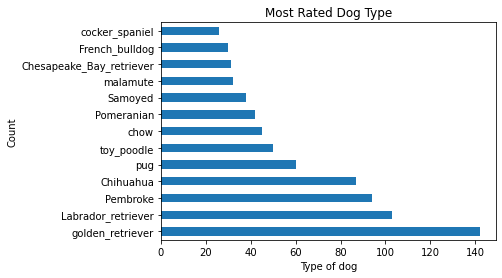

In [332]:
df_dog_type = twitter_archive_master.groupby('dog_type').filter(lambda x: len(x) >= 25)

df_dog_type["dog_type"].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Type')
plt.xlabel('Type of dog')
plt.ylabel('Count')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

### 2-Japanese_spaniel has the lowest average rating and Bouvier_des_Flandres  has the highest average rating

In [333]:
df_dog_type_mean = twitter_archive_master.groupby('dog_type').mean()
df_dog_type_sorted = df_dog_type_mean['rating'].sort_values()
df_dog_type_sorted

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
soft-coated_wheaten_terrier     8.800000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
                                 ...    
Border_terrier                 12.142857
Irish_setter                   12.333333
briard                         12.333333
Saluki                         12.500000
Bouvier_des_Flandres           13.000000
Name: rating, Length: 113, dtype: float64

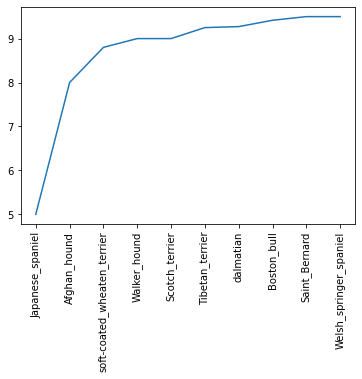

In [343]:
plt.plot(df_dog_type_sorted.head(10))
plt.xticks(rotation=90);

In [335]:
df_dog_type_mean = twitter_archive_master.groupby('dog_type').sum()[['retweet_count', 'favorite_count']]
df_dog_type_mean

,retweet_count,favorite_count
dog_type,,
Afghan_hound,6066.0,21707.0
Airedale,14216.0,56415.0
American_Staffordshire_terrier,26244.0,112893.0
Appenzeller,2441.0,13069.0
Australian_terrier,5288.0,19904.0
...,...,...
toy_poodle,92198.0,282395.0
toy_terrier,2119.0,8483.0
vizsla,21980.0,86785.0


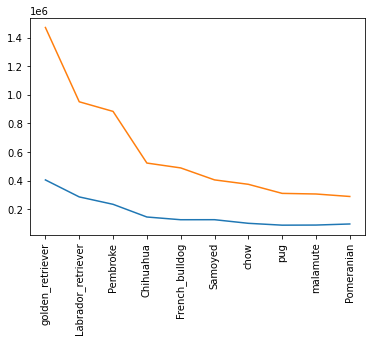

In [336]:
df_dog_type_mean.sort_values(by='favorite_count',ascending=False, inplace=True)
plt.plot(df_dog_type_mean.head(10))
plt.xticks(rotation=90);

In [337]:
df_dog_type_mean.head(10)

,retweet_count,favorite_count
dog_type,,
golden_retriever,404874.0,1470186.0
Labrador_retriever,286158.0,951048.0
Pembroke,234449.0,883770.0
Chihuahua,145771.0,522807.0
French_bulldog,126692.0,488829.0
Samoyed,126936.0,405168.0
chow,101702.0,374298.0
pug,88698.0,310847.0
malamute,89439.0,306536.0


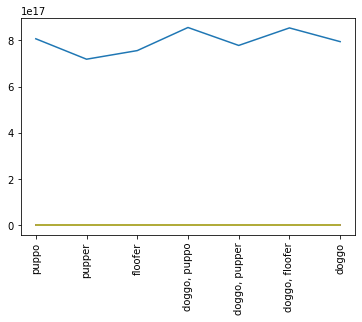

In [339]:
df_dog_type_mean = twitter_archive_master.groupby('dog_stage').mean()

df_dog_type_mean.sort_values(by='dog_stage',ascending=False, inplace=True)
plt.plot(df_dog_type_mean.head(10))
plt.xticks(rotation=90);

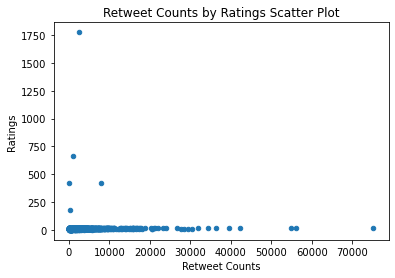

In [344]:
twitter_archive_master.plot(x='retweet_count', y='rating', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight')